<a href="https://colab.research.google.com/github/neetinds/Stock-Price-Prediction/blob/main/Amazon_Stock_Prediction_LSTM%26ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Predicting with LSTM
                                                                        

Neural Networks have been demonstrated to be very powerful in solving the real-world problems like imaging and natural language processing. Interested in stock price movements, I am therefore motivated and curious about employing nerual nets to approach financial time series problems of its kind.

Unlike common regression predictions, time series problems are more difficult due to sequence dependence within the input data variables. Among various neural nets, Long Short-Term Memory (***LSTM***), a type of recurrent neural network, has been proven to take care of complex time series predictions. So I implement LSTM to Amazon's stock prices (***AMZN***) 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras import backend as K
import math, time
import itertools
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. Load Data

Get up to five-year daily historical stock prices & volumes data from https://finance.yahoo.com/quote/AMZN/history?p=AMZN. 

Datasets consist of following columns:
- **date** Time stamp of when data was collected, being used as index column;
- **volume** The number of shares traded in AMZN during a given trading day;
- **open** The price at AMZN upon the opening of an exchange on a given trading day;
- **high** The highest price at which AMZN traded during the course of the day;
- **low** The lowest price at which AMZN traded during the course of the day;
- **close** The final price at which AMZN traded during the course of the day; it is also selected as our target data.

Plus, add a new feature based on the columns above:
- **pct** The percentage of change of close price compared to previous trading day.

In [7]:
rawdata = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction - AMZN/AMZN.csv')
## Reformat date
rawdata['Date'] = pd.to_datetime(rawdata['Date'] ,errors ='coerce')
rawdata['Date'] = pd.to_datetime(rawdata['Date'], format='%Y-%m-%d')
## Sort date by date
rawdata.sort_values(by = 'Date', ascending=True, inplace=True)
## Percentage Change
rawdata['Pct'] = rawdata['Close'].pct_change()
rawdata.dropna(inplace=True)
## Describe data
rawdata = rawdata[['Date', 'Volume', 'Open', 'High', 'Low', 'Pct', 'Close']]
rawdata.set_index('Date', inplace=True)
print('Historical stock price data for', rawdata.shape[0], 'days')
print('from', rawdata.index[0], 'to', rawdata.index[rawdata.shape[0]-1])
rawdata.head()

Historical stock price data for 2517 days
from 2010-12-07 00:00:00 to 2020-12-04 00:00:00


,Volume,Open,High,Low,Pct,Close
Date,,,,,,
2010-12-07,5077100,180.500000,181.470001,176.570007,-0.007189,176.770004
2010-12-08,3726900,177.490005,178.160004,175.199997,-0.002715,176.289993
2010-12-09,4555500,177.770004,178.110001,173.800003,-0.008168,174.850006
2010-12-10,3565500,174.880005,175.949997,173.360001,0.004404,175.619995
2010-12-13,4202500,176.330002,177.940002,173.729996,-0.007801,174.250000


#### Visualize the Ten-year daily close price data

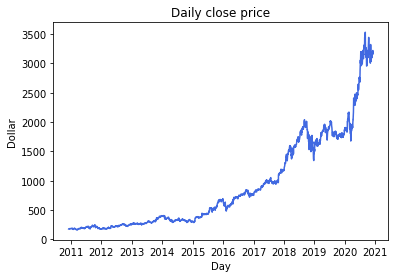

In [8]:
plt.plot(rawdata.index, rawdata['Close'], color='royalblue')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.show()

## 2. Data Preprocessing

### 2.1 Scale features

The input and output data that go into model need to be scaled. Use preprocessing.MinMaxScaler() function in scikit-learn library to scale data to the range of 0-1.

#### Scaled data

In [9]:
data=rawdata.copy()

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
data['Volume'] = min_max_scaler.fit_transform(data['Volume'].values.reshape(-1,1))
data['Open'] = min_max_scaler.fit_transform(data['Open'].values.reshape(-1,1))
data['High'] = min_max_scaler.fit_transform(data['High'].values.reshape(-1,1))
data['Low'] = min_max_scaler.fit_transform(data['Low'].values.reshape(-1,1))
data['Pct'] = min_max_scaler.fit_transform(data['Pct'].values.reshape(-1,1))
data['Close'] = min_max_scaler.fit_transform(data['Close'].values.reshape(-1,1))

data.head()

,Volume,Open,High,Low,Pct,Close
Date,,,,,,
2010-12-07,0.180442,0.005703,0.005291,0.004804,0.420312,0.004688
2010-12-08,0.122376,0.004814,0.004314,0.004393,0.436063,0.004545
2010-12-09,0.158010,0.004897,0.004300,0.003972,0.416864,0.004118
2010-12-10,0.115435,0.004043,0.003662,0.003839,0.461128,0.004347
2010-12-13,0.142829,0.004472,0.004249,0.003951,0.418158,0.003940


### 2.2 Split data to training set and test set

Split data into training (67%) and test sets (33%).

In [44]:
# split into inputs and outputs
#X, y = data[:, :-1].values, data[:, -1].values
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
print(X.shape, y.shape)

(2517, 5) (2517,)


In [45]:
# split into train test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1686, 5) (831, 5) (1686,) (831,)


In [46]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(X)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## 3. Modeling

We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
Now, it’s time to build the model. We will build the LSTM with 50 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer.

In [50]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 5))

### 3.2 Compile Network

Before training, configure the learning process by specifying:

- **Optimizer** to be 'adam';

- **Loss function** to be 'mse';

- **Evaluation metric** to be 'accuracy'.

In [51]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [52]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
24/24 [==============================] - 20s 245ms/step - loss: 0.0181
Epoch 2/100
24/24 [==============================] - 6s 253ms/step - loss: 0.0107
Epoch 3/100
24/24 [==============================] - 6s 245ms/step - loss: 0.0109
Epoch 4/100
24/24 [==============================] - 6s 243ms/step - loss: 0.0109
Epoch 5/100
24/24 [==============================] - 6s 244ms/step - loss: 0.0100
Epoch 6/100
24/24 [==============================] - 6s 242ms/step - loss: 0.0084
Epoch 7/100
24/24 [==============================] - 6s 245ms/step - loss: 0.0099
Epoch 8/100
24/24 [==============================] - 6s 243ms/step - loss: 0.0116
Epoch 9/100
24/24 [==============================] - 6s 239ms/step - loss: 0.0124
Epoch 10/100
24/24 [==============================] - 6s 244ms/step - loss: 0.0096
Epoch 11/100
24/24 [==============================] - 6s 250ms/step - loss: 0.0121
Epoch 12/100
24/24 [==============================] - 6s 242ms/step - loss: 0.0080
Epoch 13/100

### 3.3 Train Network

Fit the model to training data to learn the parameters.


### 3.4 Evaluate Network

Evaluate model on the test set

In [57]:
#Prepare the test data (reshape them):
# Getting the predicted stock price of 2017
dataset_train = data.iloc[:1000, 1:2]
dataset_test = data.iloc[1000:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
#print(inputs)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1000):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

ValueError: ignored

In [58]:
#Make Predictions using the test set
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## 4. Results

The model shows that LSTM can capture the pattern of Amazon's stock prices. However, there are some gaps between predicted and true movements. We can certainly improve the performance by further tuning the model, but the assumption of the stable status in stock market mechanism makes it hard to get significantly better results. 

Since investor behavior is highly impacted by various factors, the future idea is to add sentiment analysis to better understand investors' pyschology. Therefore, we can capture more price catalysts in the market and achieve a better prediction with a holistic view. 

In [59]:


# Calculating RMSE
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

383.9080952782968

In [64]:
plt.plot(data.loc[1000:, 'Date'],y_test.values, color = 'red', label = 'Real Amazon Stock Price')
plt.plot(data.loc[1000:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Amazon Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()

KeyError: ignored

In [ ]:

# ## Using model to predict new data

# start_date = '2018-06-09'
# end_date = '2020-06-11'

# newStockQuery = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction - AMZN/AMZN.csv')
# newStockQuery['Date'] = pd.to_datetime(newStockQuery['Date'])
# #newStockQuery.info()

# newStockQuery1 = newStockQuery[(newStockQuery['Date'] > '2018-01-01') & (newStockQuery['Date'] <= '2021-01-01')]
# #print(newStockQuery1)

# # get closing price 
# stockData = newStockQuery1.filter(['Close'])

# # get last 60 days
# last60Days = stockData[-60:].values
# normalizedData = min_max_scaler.transform(last60Days)

# # prepare new test data, normalize and reshape
# X_test = []
# X_test.append(normalizedData)

# X_test = np.array(X_test)
# X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# #X_test = np.reshape(X_test, (5000, -1))
# #X_test = np.reshape(X_test, (60, -1))
# #print(X_test)

# # predict and reverse the normalization
# predictedNew = model.predict(X_test) 
# predictedNew = min_max_scaler.inverse_transform(predictedNew)
# print('predicted price: ' + str(predictedNew))

# # Real value
# realValue = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction - AMZN/AMZN.csv')
# print(realValue['Close'])

**Stock Price Predicting with - The AutoRegressive Integrated Moving Average(ARIMA) model**



Time-series & forecasting models
Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Time-series forecasting is widely used for non-stationary data. Non-stationary data are called the data whose statistical properties e.g. the mean and standard deviation are not constant over time but instead, these metrics vary over time.
These non-stationary input data (used as input to these models) are usually called time-series. Some examples of time-series include the temperature values over time, stock price over time, price of a house over time etc. So, the input is a signal (time-series) that is defined by observations taken sequentially in time.A time series is a sequence of observations taken sequentially in time.


1.   AR: < Auto Regressive > means that the model uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).
2.   I:< Integrated > means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary
3.   MA: < Moving Average > means that the model exploits the relationship between the residual error and the observations.

**Model parameters**

The standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q.
p is the number of lag observations.
d is the degree of differencing.
q is the size/width of the moving average window.







In [127]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


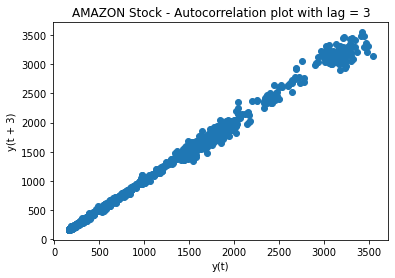

In [131]:
#Our target variable will be the Close value.
#Before building the ARIMA model, let’s see if there is some cross-correlation in out data.
plt.figure()
lag_plot(rawdata['Open'], lag=3)
plt.title('AMAZON Stock - Autocorrelation plot with lag = 3')
plt.show()


We can now confirm that ARIMA is going to be a good model to be applied to this type of data (there is auto-correlation in the data).

Finally, let’s plot the stock price evolution over time.

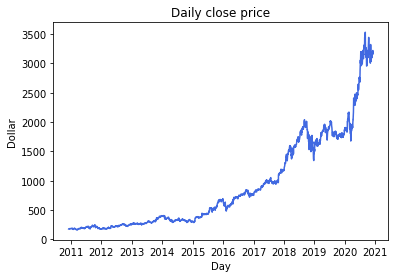

In [136]:
plt.plot(rawdata.index, rawdata['Close'], color='royalblue')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.show()

Build the predictive ARIMA model

Next, let’s divide the data into a training (60 % ) and test (40%) set. For this tutorial we select the following ARIMA parameters: p=4, d=1 and q=0.

In [140]:
train_data, test_data = rawdata[0:int(len(rawdata)*0.6)], rawdata[int(len(rawdata)*0.6):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1526.2599709816698


**Summary of the code**
We split the training dataset into train and test sets and we use the train set to fit the model, and generate a prediction for each element on the test set.
A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, we re-create the ARIMA model after each new observation is received.
Finally, we manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended at each iteration.
**Testing Mean Squared Error is 1526.2599709816698**

The MSE of the test set is quite large denoting that the precise prediction is a hard problem. However, this is the average squared value across all the test set predictions. Let’s visualize the predictions to understand the performance of the model more.

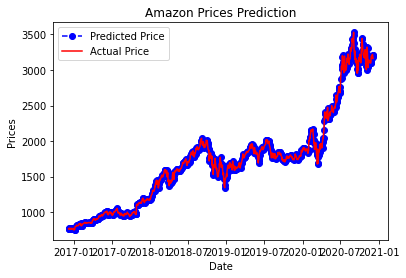

In [143]:
test_set_range = rawdata[int(len(rawdata)*0.6):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Amazon Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

ARIMA model performance on the test set

Our ARIMA model results in appreciable results. This model offers a good prediction accuracy and to be relatively fast compared to other alternatives, in terms of training/fitting time and complexity.